# `moscot-lineage` FGW regimes

This example is adapted from [Vayer et al. 2019](https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py) illustrating how `moscot-lineage` can be used to map across 1D measures. We compare the model used in `moscot-lineage`, which is Fused Gromov-Wasserstein (`FGW`), to the extremal regimes it interpolates between, which are Optimal Transport (`OT)` and Gromov-Wasserstein(`GW`).

## Import packages

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
# To use double-precision numbers (at certain cases 32 bit is insufficient). 

# from moscot import FusedGW
from ott.geometry.geometry import Geometry
from jax import numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ot

from moscot import FusedGW, GW, Regularized

## Set plotting parameters

In [3]:
sns.set_style("whitegrid", {'xtick.direction': 'out', 'xtick.major.size': 6.0, 'xtick.minor.size': 3.0,
    'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6.0, 'ytick.minor.size': 3.0, 
                           'font': ['DejaVu Sans'], 'font.scale': 1.6})

## Simulate data

In our example, we simulate `n` and `n2` samples from source (`s`) and target (`t`) distributions, respectively. Our source and target distributions are defined via a feature space (`xs` and `xt`) and a structure space (`ys` and `yt`). Samples can be compared across distributions in the feature space, but only within each distribution in the structure space.  

In [4]:
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

# source data (s)
phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

# target data (t)
phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

# uniform marginals
p = np.ones(n) / n
q = np.ones(n2) / n2

## Visualize the data
For each distribution, we visualize the structure space on the x-axis and the feature space on the y-axis. We color each dot by its y-value. 

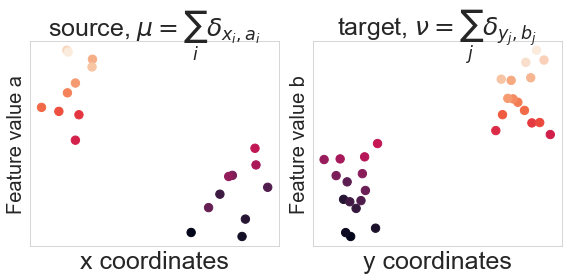

In [5]:
rows = 1
cols = 2
size  = 4

fig, axs = plt.subplots(rows, cols, figsize=(cols*(size),rows*(size)))


axs[0].scatter(ys, xs, c=phi, s=70)
axs[0].set_ylabel('Feature value a', fontsize=20)
axs[0].set_xlabel('x coordinates', fontsize=25)
axs[0].set_title('source, ' + r'$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
axs[0].set_xticks(())
axs[0].set_yticks(())


axs[1].scatter(yt, xt, c=phi2, s=70)
axs[1].set_xlabel('y coordinates', fontsize=25)
axs[1].set_ylabel('Feature value b', fontsize=20)
axs[1].set_title('target, ' + r'$\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
axs[1].set_yticks(())
axs[1].set_xticks(())

plt.tight_layout()
plt.show()


# Compute transportation maps
## Define cost matrices

In [6]:
# build structure matrices on the x-coordinates
C1 = ot.dist(xs)
C2 = ot.dist(xt)

# build feature matrix on y-coordinates (shared between both spaces)
M = ot.dist(ys, yt)

# uniform marginals
p = np.ones(C1.shape[0]) / C1.shape[0]
q = np.ones(C2.shape[0]) / C2.shape[0]

## Plot matrices

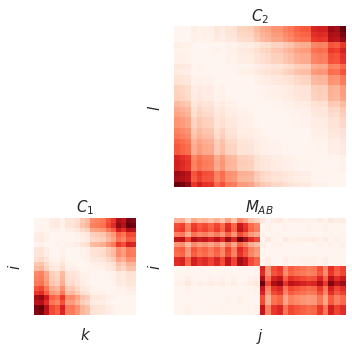

In [7]:
cmap = 'Reds'
plt.close(10)
plt.figure(10, (5, 5))
fs = 15
l_x = [0, 5, 10, 15]
l_y = [0, 5, 10, 15, 20, 25]
gs = plt.GridSpec(5, 5)

ax1 = plt.subplot(gs[3:, :2])
sns.heatmap(C1, cmap=cmap, cbar=False)
plt.title("$C_1$", fontsize=fs)
plt.xlabel("$k$", fontsize=fs)
plt.ylabel("$i$", fontsize=fs)
plt.xticks(l_x)
plt.yticks(l_x)

ax2 = plt.subplot(gs[:3, 2:])
sns.heatmap(C2, cmap=cmap, cbar=False)
plt.title("$C_2$", fontsize=fs)
plt.ylabel("$l$", fontsize=fs)
#plt.ylabel("$l$",fontsize=fs)
plt.xticks(())
plt.yticks(l_y)
ax2.set_aspect('auto')

ax3 = plt.subplot(gs[3:, 2:], sharex=ax2, sharey=ax1)
sns.heatmap(M, cmap=cmap, cbar=False)
plt.yticks(l_x)
plt.xticks(l_y)
plt.ylabel("$i$", fontsize=fs)
plt.title("$M_{AB}$", fontsize=fs)
plt.xlabel("$j$", fontsize=fs)
plt.tight_layout()
ax3.set_aspect('auto')
plt.show()

## Apply `moscot-lineage`

### FGW

In [8]:
alpha = 0.5
alpha_un= 0.95
alpha_un2 = 0.05

# scale_fn = None
scale_fn = jnp.max

## Create geometry objects used bu OTT
C1_g = Geometry(cost_matrix=jnp.asarray(C1))
C2_g = Geometry(cost_matrix=jnp.asarray(C2))
M_g = Geometry(cost_matrix=jnp.asarray(M))

# compare a range of \alpha values
fgwot_bal = FusedGW(alpha=alpha, epsilon=1e-3)
# fgwot_bal = FusedGW(alpha=alpha, epsilon=5e+1)
fgwot_bal.fit(C1_g, C2_g, M_g, p, q, scale_fn=scale_fn)

fgwot_unbal = FusedGW(alpha=alpha_un, epsilon=1e-3)
fgwot_unbal.fit(C1_g, C2_g, M_g, p, q, scale_fn=scale_fn)

fgwot_unbal2 = FusedGW(alpha=alpha_un2, epsilon=1e-3)
fgwot_unbal2.fit(C1_g, C2_g, M_g, p, q, scale_fn=scale_fn)

It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|1.501480e-01|1.000000e+00|1.501480e-01|1.000000e+00|           1|1.000000e-03
    2|7.368803e-02|1.037617e+00|7.645992e-02|1.000000e+00|           1|1.000000e-03
    3|7.211159e-02|2.186111e-02|1.576440e-03|1.000000e+00|           1|1.000000e-03
    4|7.210735e-02|5.879504e-05|4.239555e-06|1.000000e+00|           1|1.000000e-03
    5|7.210735e-02|8.625967e-08|6.219956e-09|1.000000e+00|           1|1.000000e-03
It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|2.774791e-01|1.000000e+00|2.774791e-01|1.000000e+00|           1|1.000000e-03
    2|1.271572e-01|1.182175e+00|1.503220e-01|1.000000e+00|           1|1.000000e-03
    3|1.260234e-01|8.996603e-03|1.133782e-03|1.000000e+00|           1|1.000

### GW

Use `moscot-lineage` GW solver.

In [9]:
# use moscot-lineage GW solver
gw = GW(epsilon=1e+1)
gw.fit(C1_g, C2_g, p, q)

### OT

Use moscot-lineage `Regularized` solver (implying Entropically regularized OT regime).

In [10]:
# use moscot-lineage OT solver
regot = Regularized(epsilon=1e-3)
regot.fit(M_g, p, q)

## Plot

We can compare the transportation maps found by each regime - naturally we expect that each setting will be in correlation with the structure of the costs used for it.

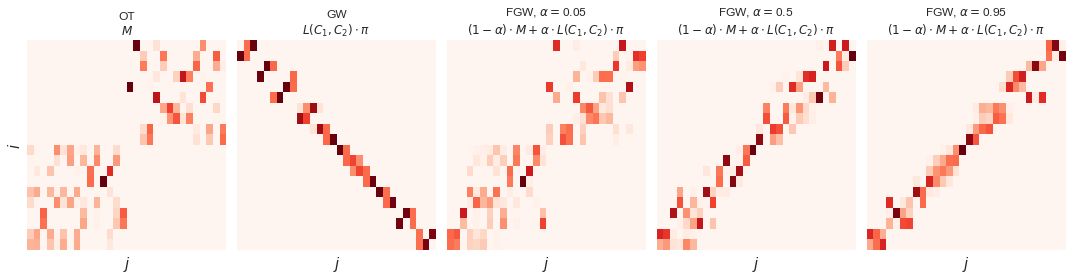

In [11]:
fs = 15
plt.figure(2, (15, 4))
plt.clf()
plt.subplot(1, 5, 1)
sns.heatmap(regot.matrix, cmap=cmap, cbar=False)
plt.ylabel("$i$", fontsize=fs)
plt.xlabel("$j$", fontsize=fs)
plt.yticks(())
plt.xticks(())
plt.title('OT'+ '\n'+ r'$M$')

plt.subplot(1, 5, 2)
sns.heatmap(gw.matrix, cmap=cmap, cbar=False)
plt.title('GW'+ '\n'+ r'$ L(C_1,C_2)\cdot \pi $')
plt.yticks(())
plt.xticks(())
plt.xlabel("$j$", fontsize=fs)


plt.subplot(1, 5, 3)
sns.heatmap(fgwot_unbal2.matrix, cmap=cmap, cbar=False)
plt.title('FGW, '+ r'$\alpha =$' +f'{alpha_un2}'+ '\n'+ r'$(1-\alpha) \cdot M + \alpha \cdot L(C_1,C_2)\cdot \pi $')
plt.yticks(())
plt.xticks(())
plt.xlabel("$j$", fontsize=fs)



plt.subplot(1, 5, 4)
sns.heatmap(fgwot_bal.matrix, cmap=cmap, cbar=False)
plt.title('FGW, '+ r'$\alpha =$' +f'{alpha}'+  '\n'+ r'$(1-\alpha) \cdot M + \alpha \cdot L(C_1,C_2)\cdot \pi $')
plt.yticks(())
plt.xticks(())
plt.xlabel("$j$", fontsize=fs)

plt.subplot(1, 5, 5)
sns.heatmap(fgwot_unbal.matrix, cmap=cmap, cbar=False)
plt.title('FGW, '+ r'$\alpha =$' +f'{alpha_un}'+ '\n'+ r'$(1-\alpha) \cdot M + \alpha \cdot L(C_1,C_2)\cdot \pi $')
plt.yticks(())
plt.xticks(())
plt.xlabel("$j$", fontsize=fs)


plt.tight_layout()
plt.show()

We can see that as expected, `OT` setting preserves the connection between sub clusters that is based on the `x`-coordinate in the spatial plot whilst `GW` and `FGW` follow the inner similarity in each space. 